In [32]:
## Load any changes to local modules
%load_ext autoreload
%autoreload 2

import os
import sys

pwd = %pwd
project_dir = '{0}/../../../'.format(pwd)
module_path = os.path.abspath(os.path.join(project_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
%matplotlib inline
from IPython.display import display

import sqlalchemy
import sqlite3

from nbcpact import AnalyzeQuantCompare,Peptide,PeptideGroup,UcbreUtils,PeptidesFromPeptideListBuilder


In [ ]:
file_path = "../../../test/data/peptideList.csv"
peptide_generator = PeptidesFromPeptideListBuilder(peptide_list_file=file_path)
peptides = peptide_generator.generate_peptides()
pep = peptides[0]

print("ip2_peptide={0}, sequence={1}, mod_locs={2}, ptm_indices={3}, area_ratio={4}".format(pep.ip2_peptide, pep.sequence, pep.mod_locs, pep.ptm_indices, pep.area_ratio))
print("area_ratios={0}, annotation={1}, uniprot_ids={2}, run_counter={3}".format(pep.area_ratios, pep.annotation, pep.uniprot_ids, pep.run_counter))
print("decoy={0},unique1={1}".format(pep.decoy, pep.unique1))


"""
ip2_peptide=None, sequence=None, mod_locs=None, ptm_indices=None, area_ratio=None,
                 area_ratios=None, annotation=None, uniprot_ids=None, run_counter=None, decoy=None,
                 unique1=None
"""

In [466]:
from enum import Enum

class DataType(Enum):
    Float = 1
    Integer = 2
    
    
class PDReader:
    
    __psm_cys_mod_pattern = re.compile(r'C(\d+)\(isoTO\w*\)')
     
    def __init__(self, pd_result_file=None, 
                 num_quant_channels=2, 
                 quan_value_names=['QuanValueIsoTOPHeavy', 'QuanValueIsoTOPLight'], 
                 pd_version='2.1'):
        
        self.__pd_result_file = pd_result_file
        self.__num_quant_channels = num_quant_channels
        self.__quan_value_names = quan_value_names
        
        self.__connection = sqlite3.connect(pd_result_file)
        self.__pd_version = pd_version
        #self.__target_psms = self.get_target_psms()
        self.__data_cache = {}
        
    def __process_psm_modifications(self, modifications):
        mod_locs = list(map(int, re.findall(self.__psm_cys_mod_pattern, modifications)))
        return mod_locs
    
    def __extract_values(self,binary_data, n=None, dataType=None):
        """
        values: bytes from the blob
        n: number of channels
        t: type of data
            'decimal' for values in decimal format such as Abundances
            'integer_number' for values such as 'Found in'

        """
        result = []

        if dataType == DataType.Float:
            for i in range(n):
                sub = binary_data[9*i:9*i+8]
                result.append(struct.unpack("d",sub)[0])
        else:
            for i in range(n):
                result.append(struct.unpack("i",binary_data[5*i:5*i+4]))

        if len(result) == 1:
            return result[0]
        else:
            return result
        
    def __get_found_raw_files(self, targetPeptideGroupsPeptideGroupID):
        df = self.get_target_psms()
        df = df[df['TargetPeptideGroupsPeptideGroupID'] == targetPeptideGroupsPeptideGroupID]
        
        values = df['SpectrumFileName'].values
        
        return values
        
    def get_target_psms(self):
        data_name = 'target_psms'
        
        ## Don't really need the quan_value_names {0} below
        if not data_name in self.__data_cache.keys():
            sqlStr = """
                        SELECT
                        Sequence,
                        ModifiedSequence,
                        Modifications,
                        ParentProteinAccessions,
                        ParentProteinDescriptions,
                        SpectrumFileName,
                        QuanChannel,
                        TargetPeptideGroupsPeptideGroupID,
                        {0}
                        FROM TargetPsms t1, TargetPeptideGroupsTargetPsms t2 
                        WHERE t1.PeptideID = t2.TargetPsmsPeptideID AND QuanChannel IS NOT NULL
                    """.format(','.join(self.__quan_value_names))
        
            df = pd.read_sql(sqlStr, self.__connection)
            self.__data_cache[data_name] = df
        
        #df['ModLocations'] = df.Modifications.apply(self.__process_psm_modifications)
        return self.__data_cache[data_name]
    
    def get_target_peptides(self):
        data_name = 'target_peptides'
        
        if not data_name in self.__data_cache.keys():
            sqlStr = """
                        SELECT
                        PeptideGroupID, 
                        Checked,
                        Confidence,
                        Sequence,
                        Modifications_all_positions,
                        Modifications_best_positions,
                        Contaminant,
                        QvalityPEP,
                        Qvalityqvalue,
                        ParentProteinGroupCount,
                        ParentProteinCount,
                        PsmCount,
                        MasterProteinAccessions,
                        MissedCleavages,
                        TheoreticalMass,
                        QuanInfo,
                        IonsScoreMascot,
                        ConfidenceMascot,
                        PercolatorqValueMascot,
                        PercolatorPEPMascot,
                        AbundanceRatios,
                        Abundances
                        FROM TargetPeptideGroups tpg
                        WHERE AbundanceRatios IS NOT NULL LIMIT 10;
                    """

            df = pd.read_sql(sqlStr, self.__connection)

            #df['mod_locs'] = df['Modifications_best_positions'].apply(self.__process_modifications)

            """
            df['ip2_peptide'] = df.apply(self.__create_ip2peptide, axis=1)

             df['str_mod_locs'] = df['mod_locs'].astype(str) # To help with merge
            df['run_counter'] = df.apply(self.__create_run_counter, axis=1)       
            """
            df['files'] = df['PeptideGroupID'].apply(self.__get_found_raw_files) 
            
            
            df['AbundanceRatios'] = df['AbundanceRatios'].apply(self.__extract_values, n=1, dataType=DataType.Float)
            df['Log2Ratio'] = df['AbundanceRatios'].apply(np.log2)

            #df['ptm_indices'] = df.apply(self.__get_global_mod_position, axis=1)

            df = df.drop(['Abundances'], axis=1)

            self.__data_cache[data_name] = df
            
        return self.__data_cache[data_name]


file_path = '/usca/asperapoc/NB-CPACT/NB-CPACT-NIBR/NIBR_loaded_UCB_EN80/Analysis/PD2.1/KEA_isoTOP_DN_All.pdResult'
proteomeDiscovererReader = PDReader(pd_result_file=file_path, num_quant_channels=2)

psms = proteomeDiscovererReader.get_target_psms()
pepGroup = proteomeDiscovererReader.get_target_peptides()


display(psms.head())

display(pepGroup.head())


,Sequence,ModifiedSequence,Modifications,ParentProteinAccessions,ParentProteinDescriptions,SpectrumFileName,QuanChannel,TargetPeptideGroupsPeptideGroupID,QuanValueIsoTOPHeavy,QuanValueIsoTOPLight
0,DNLTLWTSDSAGEECDAAEGAEN,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTO),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN801_1.raw,IsoTOP Light,621,41102434.50,5.011258e+07
1,DNLTLWTSDSAGEECDAAEGAEN,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTO),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN801_1.raw,IsoTOP Light,621,15886787.75,1.967504e+07
2,DNLTLWTSDSAGEECDAAEGAEN,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTOR0),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN801_1.raw,IsoTOP Heavy,622,15886787.75,1.967504e+07
3,AAAPAPEEEMDECEQALAAEPK,AAAPAPEEEMDEcEQALAAEPK,C13(isoTO),P26641,GN=EEF1G Elongation factor 1-gamma OS=Homo sap...,KEA_EN801_1.raw,IsoTOP Light,799,91376038.50,1.445624e+08
4,AAAPAPEEEMDECEQALAAEPK,AAAPAPEEEMDEcEQALAAEPK,C13(isoTOR0),P26641,GN=EEF1G Elongation factor 1-gamma OS=Homo sap...,KEA_EN801_1.raw,IsoTOP Heavy,800,91376038.50,1.445624e+08


,PeptideGroupID,Checked,Confidence,Sequence,Modifications_all_positions,Modifications_best_positions,Contaminant,QvalityPEP,Qvalityqvalue,ParentProteinGroupCount,...,MissedCleavages,TheoreticalMass,QuanInfo,IonsScoreMascot,ConfidenceMascot,PercolatorqValueMascot,PercolatorPEPMascot,AbundanceRatios,files,Log2Ratio
0,378,0,2,LCSLMGTVFLLR,1×Oxidation [M5]; 1×isoTOP TEV heavy [C2],1×Oxidation [M5]; 1×isoTOP TEV heavy [C2],1,0.249299,0.012863,1,...,0,1896.059015,9,9.37,3,0.006328,1.336000e-01,0.010000,[KEA_EN802_4.raw],-6.643856
1,391,0,3,CMVQFVGR,1×isoTOP TEV Light [C1],1×isoTOP TEV Light [C1],1,0.034045,0.001524,1,...,0,1460.761320,9,23.22,3,0.000643,8.399000e-03,1.651905,[KEA_EN801_4.raw],0.724131
2,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,0,2919.269734,9,26.79,3,0.000000,6.798000e-08,1.051228,"[KEA_EN801_1.raw, KEA_EN801_1.raw, KEA_EN803_2...",0.072076
3,622,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV heavy [C15],1×isoTOP TEV heavy [C15],1,0.000842,0.000000,1,...,0,2925.283543,9,19.67,3,0.000000,9.023000e-05,1.366417,"[KEA_EN801_1.raw, KEA_EN803_2.raw, KEA_EN803_3...",0.450398
4,770,0,3,EDLNCQEEEDPMNK,1×isoTOP TEV Light [C5],1×isoTOP TEV Light [C5],1,0.000685,0.000000,1,...,0,2214.975407,9,39.94,3,0.000000,7.002000e-05,1.108190,"[KEA_EN803_3.raw, KEA_EN803_3.raw]",0.148205


In [458]:

        
        

#display(pepGroup['AbundanceRatios'].apply(__extract_values, dataType=DataType.Float))
df=pepGroup.head(3)
df_with_psm = df.merge(psms, how='left')

display(df['FoundinSamples'].apply(__extract_values, dataType=DataType.String))
#help(struct)

#pepGroup.head(1)

df_with_psm  

0    [(0,), (4,)]
1    [(4,), (1,)]
2    [(4,), (1,)]
Name: FoundinSamples, dtype: object

,PeptideGroupID,Checked,Confidence,Sequence,Modifications_all_positions,Modifications_best_positions,Contaminant,QvalityPEP,Qvalityqvalue,ParentProteinGroupCount,...,ModifiedSequence,Modifications,ParentProteinAccessions,ParentProteinDescriptions,SpectrumFileName,QuanChannel,TargetPeptideGroupsPeptideGroupID,QuanValueIsoTOPHeavy,QuanValueIsoTOPLight,ModLocations
0,378,0,2,LCSLMGTVFLLR,1×Oxidation [M5]; 1×isoTOP TEV heavy [C2],1×Oxidation [M5]; 1×isoTOP TEV heavy [C2],1,0.249299,0.012863,1,...,LcSLmGTVFLLR,C2(isoTOR0); M5(Oxidation),Q96LT4,GN=SAMD8 Sphingomyelin synthase-related protei...,KEA_EN802_4.raw,IsoTOP Heavy,378,4.016555e+05,NaN,[2]
1,391,0,3,CMVQFVGR,1×isoTOP TEV Light [C1],1×isoTOP TEV Light [C1],1,0.034045,0.001524,1,...,cMVQFVGR,C1(isoTO),Q9NZJ7,GN=MTCH1 Mitochondrial carrier homolog 1 OS=Ho...,KEA_EN801_4.raw,IsoTOP Light,391,4.279461e+05,7.069264e+05,[1]
2,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTO),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN801_1.raw,IsoTOP Light,621,4.110243e+07,5.011258e+07,[15]
3,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTO),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN801_1.raw,IsoTOP Light,621,1.588679e+07,1.967504e+07,[15]
4,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTOR0),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN801_1.raw,IsoTOP Heavy,622,1.588679e+07,1.967504e+07,[15]
5,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTO),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN803_2.raw,IsoTOP Light,621,2.874193e+07,4.078711e+07,[15]
6,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTOR0),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN803_2.raw,IsoTOP Heavy,622,2.874193e+07,4.078711e+07,[15]
7,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTO),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN803_2.raw,IsoTOP Light,621,9.404085e+06,2.981306e+06,[15]
8,621,0,3,DNLTLWTSDSAGEECDAAEGAEN,1×isoTOP TEV Light [C15],1×isoTOP TEV Light [C15],1,0.000003,0.000000,1,...,DNLTLWTSDSAGEEcDAAEGAEN,C15(isoTOR0),P27348,GN=YWHAQ 14-3-3 protein theta OS=Homo sapiens ...,KEA_EN803_3.raw,IsoTOP Heavy,622,3.541362e+06,5.358270e+06,[15]


In [404]:
class PeptideFromPD2_1Generator:
    
    __psm_cys_mod_pattern = re.compile(r'C(\d+)\(isoTO\w*\)')
    __exp_pattern = r'(KEA_EN80\d)_\d.raw'
    __peptide_mod_pattern = re.compile(r'.*\d.isoTOP TEV [heavyLight]+ \[(.+)\].*')
    __peptide_cys_mod_pattern = re.compile(r'C(\d+)')
    
    __data_cache = {}

    
    def __init__(self, pd_study_dir="/usca/asperapoc/NB-CPACT/NB-CPACT-NIBR/NIBR_loaded_UCB_EN80/Analysis/PD2.1/"):
        self.__pd_study_dir = pd_study_dir
        # TODO: Look for the latest pdResult file
        file_path = '{0}/{1}'.format(pd_study_dir, 'KEA_isoTOP_DN_All.pdResult')
        self.__connection = sqlite3.connect(file_path)
        self.__target_psms = self.get_target_psms()
        modifications = self.get_found_modifications()
        
        value = float(modifications[modifications['Name'] == 'IsoTOP heavy']['DeltaMonoisotopicMass'])
        self.__isoTopHeavyMass = "{0:.2f}".format(value)
        value = float(modifications[modifications['Name'] == 'IsoTOP light']['DeltaMonoisotopicMass'])
        self.__isoTopLightMass = "{0:.2f}".format(value)
        
    
    def __process_psm_modifications(self, modifications):
        mod_locs = list(map(int, re.findall(self.__psm_cys_mod_pattern, modifications)))
        return mod_locs
    
    def get_found_modifications(self):
        sqlStr = "SELECT * FROM FoundModifications"
        df = pd.read_sql(sqlStr, self.__connection)
        return df
    
    def get_target_psms(self):
        sqlStr = """
        SELECT
        Sequence,
        ModifiedSequence,
        Modifications,
        ParentProteinAccessions,
        ParentProteinDescriptions,
        SpectrumFileName,
        QuanChannel,
        QuanValueIsoTOPLight,
        QuanValueIsoTOPHeavy
        FROM TargetPsms
        WHERE (QuanChannelID = 1 OR QuanChannelID = 2)
        """
        df = pd.read_sql(sqlStr, self.__connection)
        
        df['mod_locs'] = df.Modifications.apply(self.__process_psm_modifications)
        df['str_mod_locs'] = df['mod_locs'].astype(str)
        df['EXPERIMENT'] = df.SpectrumFileName.str.extract(self.__exp_pattern)
        
        return df
    
    
    
    def __process_modifications(self, modifications):
        match = self.__peptide_mod_pattern.match(modifications)
        if match:
            mod_locs = list(map(int, re.findall(self.__peptide_cys_mod_pattern, match.group(1))))
            return mod_locs
        
    
    def __create_run_counter(self, row, experiments=['KEA_EN801', 'KEA_EN802', 'KEA_EN803']):
        sequence = row['Sequence']
        mod_locs = str(row['str_mod_locs'])
        targetPsmsDF = self.__target_psms
        
        psms = targetPsmsDF[(targetPsmsDF.Sequence == sequence) & (targetPsmsDF['str_mod_locs'] == mod_locs)]
        psm_exps = list(psms['EXPERIMENT'])
        run_counter = [i in psms_exps for i in experiments]

        return str(run_counter)
    
    def __get_global_mod_position(self, row):
        data_cache_name = 'target_prot_sequences'
        
        if not data_cache_name in self.__data_cache.keys():
            sqlStr = """
                        SELECT
                        t1.PeptideGroupID,t3.Sequence
                        FROM TargetPeptideGroups t1,
                        TargetPeptideGroupsTargetProteins t2,
                        TargetProteins t3
                        WHERE t1.PeptideGroupID = t2.TargetPeptideGroupsPeptideGroupID
                        AND t2.TargetProteinsUniqueSequenceID = t3.UniqueSequenceID
                    """
            
            df = pd.read_sql(sqlStr, self.__connection)
            self.__data_cache[data_cache_name] = df
            
        peptide_sequence = row['Sequence']
        
        local_positions = [int(numeric_string) for numeric_string in  row['mod_locs']]
        peptideGroupID = row['PeptideGroupID']
        
        df = self.__data_cache[data_cache_name]
        proteinSequences = df[df['PeptideGroupID'] == peptideGroupID]['Sequence']
        
        peptide_starts = []
        for proteinSequence in proteinSequences.values:
            peptide_starts.append((proteinSequence.find(peptide_sequence)))
            
        global_positions = []
        for peptide_start in peptide_starts:      
            pos_strings = []

            for local_position in local_positions:
                global_pos = np.nan if peptide_start == -1 else (local_position + peptide_start)
                pos_strings.append('C{0}'.format(global_pos))

            global_positions.append(','.join(pos_strings))
            
        
        return global_positions   
    
    def __create_ip2peptide(self, row):

        modifications = row['Modifications_best_positions']
        sequence = row['Sequence']
        mod_locs = row['mod_locs']
        
        mass = modifications
        if 'isoTOP TEV heavy' in modifications:
            mass = self.__isoTopHeavyMass
        elif 'isoTOP TEV Light' in modifications:
            mass = self.__isoTopLightMass
            
        for mod_loc in mod_locs:
            sequence = '{0}C({1}){2}'.format(sequence[0:mod_loc-1], mass, sequence[mod_loc:])

        return sequence


    def __extract_values(self, binary_data, n=None, dataType=None):
        """
        values: bytes from the blob
        n: number of channels
        t: type of data
            'decimal' for values in decimal format such as Abundances
            'integer_number' for values such as 'Found in'

        """
        result = []

        if dataType == DataType.Float:
            for i in range(n):
                sub = binary_data[9*i:9*i+8]
                result.append(struct.unpack("d",sub)[0])
        else:
            return binary_data

        if len(result) == 1:
            return result[0]
        else:
            return result
    
    
    def get_target_peptides_from_pdresult(self):
        sqlStr = """
            SELECT
            PeptideGroupID, 
            Checked,
            Confidence,
            Sequence,
            Modifications_all_positions,
            Modifications_best_positions,
            Contaminant,
            QvalityPEP,
            Qvalityqvalue,
            ParentProteinGroupCount,
            ParentProteinCount,
            PsmCount,
            MasterProteinAccessions,
            MissedCleavages,
            TheoreticalMass,
            QuanInfo,
            IonsScoreMascot,
            ConfidenceMascot,
            PercolatorqValueMascot,
            PercolatorPEPMascot,
            AbundanceRatios,
            Abundances,
            FoundinSamples
            FROM TargetPeptideGroups tpg
            WHERE AbundanceRatios IS NOT NULL LIMIT 10;
            """
        
        df = pd.read_sql(sqlStr, self.__connection)
        
        df['mod_locs'] = df['Modifications_best_positions'].apply(self.__process_modifications)
        
        df['ip2_peptide'] = df.apply(self.__create_ip2peptide, axis=1)
        
        df['str_mod_locs'] = df['mod_locs'].astype(str) # To help with merge
        df['run_counter'] = df.apply(self.__create_run_counter, axis=1)       
        
        #df['AbundanceRatios'] = df['AbundanceRatios'].apply(self.__extract_values, n=1, dataType=DataType.Float)
        df['Log2Ratio'] = df['AbundanceRatios'].apply(np.log2)
        
        df['ptm_indices'] = df.apply(self.__get_global_mod_position, axis=1)
        
        df = df.drop(['Abundances', 'FoundinSamples'], axis=1)
        
        return df
    
    def get_target_peptides(self):
        # TODO: Look for any xlsx file
        file_path = "{0}/KEA_isoTOP_DN_High_Med_All.xlsx".format(self.__pd_study_dir)
        df = pd.read_excel(file_path)
        ## Clean up dataframe
        df = df[~df['Abundance Ratio (log2): (IsoTOP Light) / (IsoTOP Heavy)'].isnull()]
        df['mod_locs'] = df['Modifications'].apply(self.__process_modifications)
        df['run_counter'] = df.apply(self.__create_run_counter, axis=1)
        
        return df

pep_generator = PeptideFromPD2_1Generator()

/home/jonesmic/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:53: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


## 

In [ ]:
peptide_from_pdresultsDF = pep_generator.get_target_peptides_from_pdresult()
peptide_from_pdresultsDF.T

In [ ]:
sequence = 'SDFCSDFSDCSDFSDFSDF'

mod_loc=4
mass = '123.00'

sequence[0:mod_loc-1] + 'C' + mass + sequence[mod_loc:]

In [ ]:
data = {}

## Transfer some values directly
data['uniprot_ids'] = peptide_from_pdresultsDF['MasterProteinAccessions']
data['area_ratio'] = peptide_from_pdresultsDF['AbundanceRatios']
data['sequence'] = peptide_from_pdresultsDF['Sequence']



# Do later
## TODO: Global PTM
data['ptm_indices'] = peptide_from_pdresultsDF['ptm_indices']
## Detailed protein annot
data['annotation'] = None
## The IP2 semicolon array that RunCounter is made from
data['unique1'] = None

data['run_counter'] = peptide_from_pdresultsDF['run_counter']
## Decoy is always false as the SQL Takes care of that. 
data['decoy'] = False
## TODO: Create ip2_peptide
ip2_peptide=peptide_from_pdresultsDF['ip2_peptide']

df = pd.DataFrame(data=data)


In [ ]:
def __init_peptide(self, row):
    peptide = Peptide(sequence=row['sequence'],
                      mod_locs=row['mod_locs'],
                      ptm_indices=row['ptm_indices'],
                      area_ratio=row['area_ratio'],
                      area_ratios=row['area_ratios'],
                      annotation=row['annotation'],
                      uniprot_ids=row['uniprot_ids'],
                      run_counter=row['run_counter'],
                      decoy=row['decoy'],
                      unique1=row['UNIQUE_1'],
                      ip2_peptide=row['ip2_peptide'])

        return peptide

df.apply(__init_peptide)

In [ ]:
pepgroup_df[pepgroup_df.Sequence == 'CGEEIAVQFVDMVK']

In [ ]:
x = b'\x06\x00\x00\x00c@sA\x01\xfe\xff\xffG\x8b\x7feA\x01'

from enum import Enum

class DataType(Enum):
    Float = 1

def extract_values(binary_data, n=None, dataType=None):
    """
    values: bytes from the blob
    n: number of channels
    t: type of data
        'decimal' for values in decimal format such as Abundances
        'integer_number' for values such as 'Found in'

    """
    result = []
    
    if dataType == DataType.Float:
        for i in range(n):
            sub = binary_data[9*i:9*i+8]
            result.append(struct.unpack("d",sub)[0])
    else:
        return binary_data

    if len(result) == 1:
        return result[0]
    else:
        return result
    
file_path = "/usca/asperapoc/NB-CPACT/NB-CPACT-NIBR/NIBR_loaded_UCB_EN80/Analysis/PD2.1/KEA_isoTOP_DN_All.pdResult"
pd_connection = sqlite3.connect(file_path)

sqlStr = """
            SELECT Sequence, Abundances, AbundanceRatios, FoundInSamples FROM TargetPeptideGroups tpg 
            WHERE AbundanceRatios IS NOT NULL AND Sequence = 'CGEEIAVQFVDMVK'
        """
targetPeptideGroupsDF = pd.read_sql(sqlStr, pd_connection)
print(targetPeptideGroupsDF.AbundanceRatios.apply(extract_values, n=1, dataType=DataType.Float).apply(np.log2))
print(targetPeptideGroupsDF.Abundances.apply(extract_values, n=2, dataType=DataType.Float))
print(targetPeptideGroupsDF.FoundinSamples.apply(extract_values, n=1))

In [ ]:
peptide_df[peptide_df.Sequence == 'CGEEIAVQFVDMVK'].T

In [ ]:
def unpack_type(barray, n, t):
    """
    extract BLOB from pdResult file
    barray: barray that holds blob
    n: number of channels
    t: type of data
        'decimal' for values in decimal format such as Abundances
        'integer_number' for values such as 'Found in'

    """
    
    tmp = []
    if barray:
        if t == 'decimal':
            for i in range(n):
                tmp.append(struct.unpack("d",barray[9*i:9*i+8]))
        if ((t == 'integer_number') or (t == 'integer_text')):
            for i in range(n):
                tmp.append(struct.unpack("i",df[5*i:5*i+4]))
    # take care of the missing values     
    else: 
        if t == 'decimal':
            tmp = [0.0]*n    
        if ((t == 'integer_number') or (t == 'integer_text')):
            tmp = [0]*n

    return tmp


barray = b'{\x14\xaeG\xe1z\x84?\x01'
unpack_type(barray, 5, 'decimal')

In [35]:
import ipywidgets as widgets

w = widgets.Select(
    options=['Apples', 'Oranges', 'Pears'],
    value='Oranges',
    #rows=10,
    description='Fruits',
    disabled=False
)

def on_value_change(change):
    print(change['new'])

w.observe(on_value_change, names='value')

display(w)

Apples
Pears
Oranges
Apples
Pears
Oranges
Apples
Oranges
Pears
Oranges
Apples
Pears
Oranges
Apples
Oranges
Pears
Oranges
Apples
Oranges
Pears
Apples
Oranges
Pears


In [7]:
class SimplePeptide:
    """
        This allows comparisons between peptide sequences that are nearly identical
        except for the Isboaric Isoleucine and Leucine [IL]. MS Proteomics is based on 
        identifying peptides based on their fragment mass profiles. Since [IL] have the 
        same mass they can not be differentiated. 
        
        The equals is acomplished by a simple replacement of all [IL] in the sequence with 
        the string [IL]. Then an exact match (No Regex matching needed) is the most efficient 
        way to match two peptides. 
        
        You could also use the complied pattern to do a RegEx pattern search against a larger sequence. 
        
        This was really for putting the object into a Pandas DF
        pdDF['SIMPLE_PEP'] = pdDF['Sequence'].apply(lambda x: SimplePeptide(x))
    """
    
    def __init__(self, sequence):
        self.sequence = sequence
        self.pattern_string = re.sub('[IL]', '[IL]', sequence)
        self.pattern = re.compile(self.pattern_string)
        self.myhash = hash(self.pattern_string)

    def __eq__(self, other):
        if isinstance(self, other.__class__):
            return bool(self.pattern_string == other.pattern_string)
        return False
    
    def __hash__(self):
        return self.myhash
    
    def __lt__(self, other):
        return self.pattern_string < other.pattern_string
    
    def __str__(self):
        return self.sequence
    
pep1 = SimplePeptide('SDFSDFSDFLSDFISDFR')
pep2 = SimplePeptide('SDFSDFSDFLSDFISDFR')
pep3 = SimplePeptide('SDFSDFSDFISDFLSDFR')
pep4 = SimplePeptide('XZCZXCZXCIZXCLSDFR')

print('{} = {} ? {}'.format(pep1, pep2, (pep1==pep2))) # SDFSDFSDFLSDFISDFR = SDFSDFSDFLSDFISDFR ? True
print('{} = {} ? {}'.format(pep1, pep3, (pep1==pep3))) # SDFSDFSDFLSDFISDFR = SDFSDFSDFISDFLSDFR ? True
print('{} = {} ? {}'.format(pep1, pep4, (pep1==pep4))) # SDFSDFSDFLSDFISDFR = XZCZXCZXCIZXCLSDFR ? False

SDFSDFSDFLSDFISDFR = SDFSDFSDFLSDFISDFR ? True
SDFSDFSDFLSDFISDFR = SDFSDFSDFISDFLSDFR ? True
SDFSDFSDFLSDFISDFR = XZCZXCZXCIZXCLSDFR ? False


,SAMPLE_NAME,VCF_URI,BAM_URI,CONCEPT_NAME,SAMPLE_TYPE,SAMPLE_SOURCE,CONCEPT_SMFID,SAMPLE_SMFID,Primary Site
975,CLR9938,file://rogue/dlab/NGS/NGS_Data/Novartis/RNA-se...,file://rogue/dlab/NGS/NGS_Data/Novartis/RNA-se...,yuduty_unknown,CellLine,CCLE2,FW37-33CA,NS,unknown


lung                                  174
haematopoietic and lymphoid tissue    169
skin                                   67
large intestine                        61
breast                                 60
central nervous system                 49
ovary                                  46
pancreas                               41
stomach                                37
upper aerodigestive tract              31
endometrium                            28
oesophagus                             26
urinary tract                          25
liver                                  25
soft tissue                            24
kidney                                 23
autonomic ganglia                      16
bone                                   15
eye                                    13
pleura                                 12
thyroid                                11
biliary tract                           8
prostate                                8
salivary gland                    

Lineages covered: 26


TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

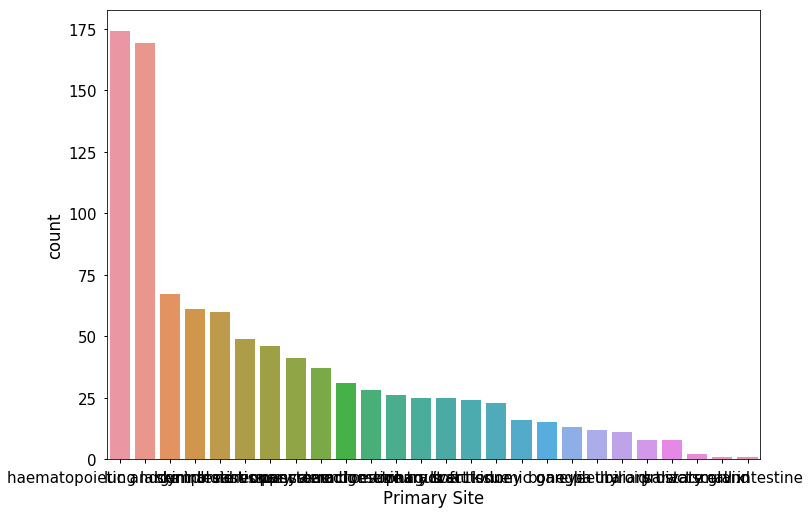

In [50]:
from matplotlib import pyplot
file_path = 'http://nrusca-ldl30114.nibr.novartis.net/~jonesmic/projects/2018/onc_legacy/CCLE_Full_MutSampleDetails.txt'

df = pd.read_table(file_path)

primary_site = 'Primary Site'

df[primary_site] = df['CONCEPT_NAME'].apply(lambda x : ' '.join(x.split('_')[1:]))
display(df[df[primary_site]== 'unknown'])
df = df[df[primary_site] != '']
df = df[df[primary_site] != 'unknown']
display(df[primary_site].value_counts())
print('Lineages covered: {}'.format(len(df[primary_site].unique())))



ax = sns.countplot(x=primary_site, data=df, order=df[primary_site].value_counts().index, ax=ax)
ax.set_xticklabels(rotation=90)

file_path='/home/jonesmic/clip/CCLE_PrimarySite'
plt.savefig(file_path, bbox_inches='tight')

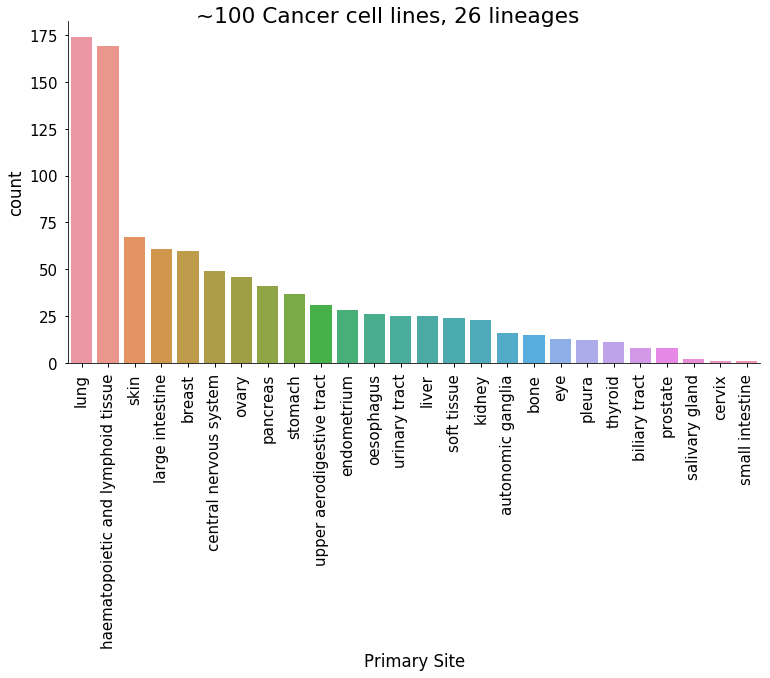

In [60]:
#a4_dims = (11.7, 8.27)
#fig, ax = pyplot.subplots(figsize=a4_dims)

g = sns.factorplot(x=primary_site, data=df, 
                   aspect=2, 
                   size=6, 
                   kind="count", order = df[primary_site].value_counts().index)
g.set_xticklabels(rotation=90)
g.fig.suptitle('~100 Cancer cell lines, 26 lineages')



file_path='/home/jonesmic/clip/CCLE_PrimarySite.png'
plt.savefig(file_path, bbox_inches='tight')